## EMアルゴリズムの実装

In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data_name = 'old_faithful'
path = os.path.join(data_name + '.txt')
xs = np.loadtxt(path)

print(xs.shape)

(272, 2)


In [3]:
phis = np.array([0.5, 0.5])
mus = np.array([[2, 60], [4, 80]])
covs = np.array([np.eye(2), np.eye(2)])

K = len(phis) # ガウス分布の数
N = len(xs) # データ数
MAX_ITERS = 100
THRESHOLD = 1e-4

In [4]:
def multivariate_normal(x, mu, cov):
    """
    多変量ガウス分布

    :param x: 入力
    :param mu: 平均
    :param cov: 共分散行列

    :return: 確率密度
    """
    det = np.linalg.det(cov) # 行列式
    inv = np.linalg.inv(cov) # 逆行列
    D = len(x)
    z = 1 / np.sqrt((2 * np.pi) ** D * det)
    y = z * np.exp(-0.5*(x - mu).T @ inv @ (x - mu))
    return y

def gmm(x, phis, mus, covs):
    """
    ガウス混合モデル

    :param x: 入力
    :param phis: 混合係数
    :param mus: 平均
    :param covs: 共分散行列

    :return: 確率密度
    """
    K = len(phis)
    y = 0
    for k in range(K):
        y += phis[k] * multivariate_normal(x, mus[k], covs[k])
    return y

def likelihood(xs, phis, mus, covs):
    """
    尤度

    :param xs: 入力
    :param phis: 混合係数
    :param mus: 平均
    :param covs: 共分散行列

    :return: 全データに対する平均対数尤度
    """
    eps = 1e-8 # log(0)を防ぐための微小値
    L = 0 # 対数尤度
    N = len(xs) # データ数
    for x in xs:
        y = gmm(x, phis, mus, covs)
        L += np.log(y + eps)

    return L / N

In [5]:
current_likelihood = likelihood(xs, phis, mus, covs) # 現在の対数尤度

for iter in range(MAX_ITERS):
    qs = np.zeros((N, K)) # q(k)

    ### E-step
    for n in range(N):
        x = xs[n]
        for k in range(K):
            phi, mu, cov = phis[k], mus[k], covs[k]
            qs[n, k] = phi * multivariate_normal(x, mu, cov)
        qs[n] /= gmm(x, phis, mus, covs)

    ### M-step
    qs_sum = np.sum(qs, axis=0) # (K,)
    for k in range(K):
        # update phi
        phis[k] = qs_sum[k] / N

        # update mu
        c = 0
        for n in range(N):
            c += qs[n, k] * xs[n]
        mus[k] = c / qs_sum[k]

        # update cov
        c = 0
        for n in range(N):
            z = xs[n] - mus[k] # (D,)
            z = z[:, np.newaxis] # (D, 1)
            c += qs[n, k] * z @ z.T # (D, D)
        covs[k] = c / qs_sum[k]

    ### 終了判定
    print(f"Currenr likelihood: {current_likelihood:.3f}")

    next_likelihood = likelihood(xs, phis, mus, covs)
    diff = np.abs(next_likelihood - current_likelihood)
    if diff < THRESHOLD:
        print(f"Converged. diff: {diff:.3f}")
        print("Finished EM algorithm.")
        break

    current_likelihood = next_likelihood

Currenr likelihood: -11.765
Currenr likelihood: -4.406
Currenr likelihood: -4.314
Currenr likelihood: -4.283
Currenr likelihood: -4.281
Currenr likelihood: -4.281
Converged. diff: 0.000
Finished EM algorithm.


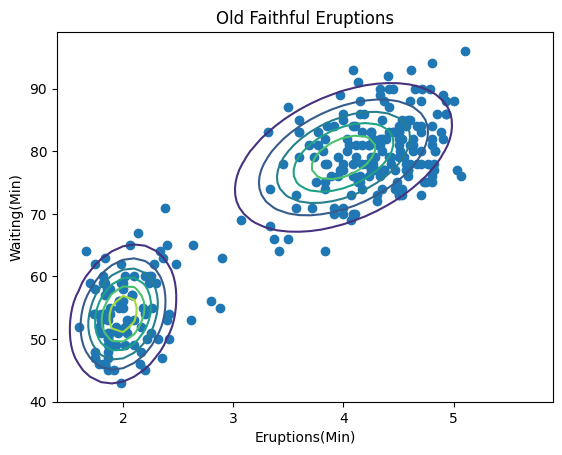

In [7]:
data_name = 'old_faithful'
path = os.path.join(data_name + '.txt')
xs = np.loadtxt(path)

X, Y = np.meshgrid(np.arange(1.4, 6.0, 0.1), np.arange(40, 100, 1))
Z = np.zeros(X.shape)

for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        x = np.array([X[i, j], Y[i, j]])
        Z[i, j] = gmm(x, phis, mus, covs)

plt.contour(X, Y, Z)
plt.scatter(xs[:, 0], xs[:, 1])
plt.xlabel('Eruptions(Min)') # 噴出した時間
plt.ylabel('Waiting(Min)') # 次の噴火までの待ち時間
plt.title('Old Faithful Eruptions')
plt.show()

Text(0.5, 1.0, 'Generated Data')

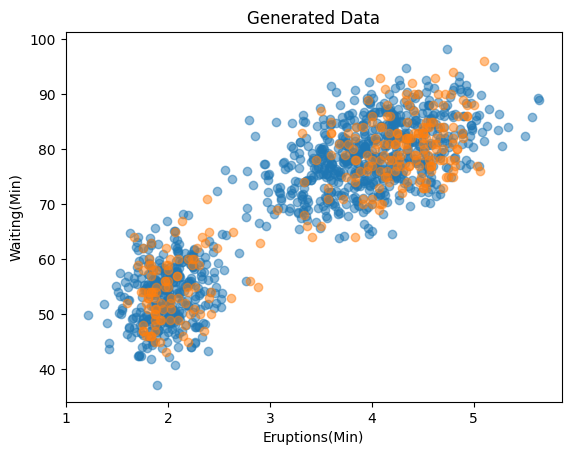

In [8]:
N = 1000
new_xs = np.zeros((N, 2))

for n in range(N):
    k = np.random.choice(K, p=phis)
    new_x = np.random.multivariate_normal(mus[k], covs[k])
    new_xs[n] = new_x

plt.scatter(new_xs[:, 0], new_xs[:, 1], label='Generated Data', alpha=0.5)
plt.scatter(xs[:, 0], xs[:, 1], label='Real Data', alpha=0.5)
plt.xlabel('Eruptions(Min)') # 噴出した時間
plt.ylabel('Waiting(Min)') # 次の噴火までの待ち時間
plt.title('Generated Data')